In [1]:
import numpy as np
import pymc3 as pm

/usr/local/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
from scipy import stats

In [4]:
sns.set_context('notebook')
plt.style.use(['classic', 'seaborn-whitegrid'])

## T-test

In [92]:
# Data

mu1, std1 = 5, 5
group1 = stats.norm.rvs(loc=mu1, scale=std1, size=100)

mu2, std2 = 10, 3
group2 = stats.norm.rvs(loc=mu2, scale=std2, size=100)

In [100]:
# model
with pm.Model() as ttest:
    mu1e = pm.Normal('mu1', mu=group1.mean(), sd=.1)
    std1e = pm.Uniform('std1', lower=0, upper=10)
    g1 = pm.Normal('group1', mu=mu1e, sd=std1e, observed=group1)
    
    mu2e = pm.Normal('mu2', mu=group2.mean(), sd=.1)
    std2e = pm.Uniform('std2', lower=0, upper=10)
    g2 = pm.Normal('group2', mu=mu2e, sd=std2e, observed=group2)
    
    # test
    mean_dif = pm.Deterministic('Mean dif', mu1e-mu2e)
    std_dif = pm.Deterministic('Std dif', std1e-std2e)


INFO (theano.gof.compilelock): Refreshing lock /Users/semio/.theano/compiledir_Darwin-15.2.0-x86_64-i386-64bit-i386-3.5.0-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /Users/semio/.theano/compiledir_Darwin-15.2.0-x86_64-i386-64bit-i386-3.5.0-64/lock_dir/lock


In [101]:
# sampling
with ttest:
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(10000, step, start, progressbar=False)

In [103]:
pm.summary(trace[1000::10], vars=['Mean dif', 'Std dif'])


Mean dif:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -6.156           0.136            0.005            [-6.408, -5.893]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -6.406         -6.258         -6.154         -6.063         -5.888


Std dif:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  2.553            0.451            0.015            [1.593, 3.396]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  1.696          2.255          2.547          2.834          3.542



## Linear Regression

In [111]:
x = np.linspace(0, 20, 20)

a, b = 3, 5

y = a * x + b + stats.t.rvs(df=1, scale=3, size=np.size(x))

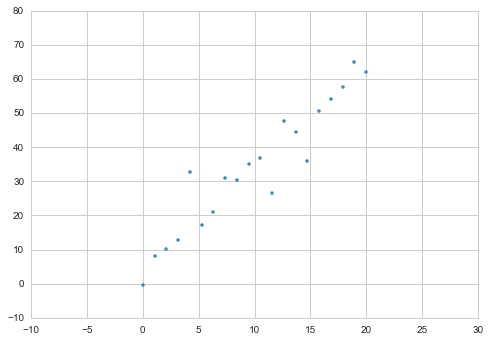

In [112]:
plt.plot(x, y, '.')

plt.xlim((-10, 30))
plt.ylim((-10, 80))
plt.show()

In [65]:
np.median(y) / np.median(x)

3.3854675708016941

In [113]:
with pm.Model() as linreg:
    ma = pm.Normal('alpha', mu=4, sd=2)
    mb = pm.Normal('beta', mu=7, sd=3)
    
    mu = ma * x + mb
    nu = pm.Exponential('nu', lam=2)
    lam = pm.Uniform('lam', 0, 5)
    
    my = pm.T('Y', nu=nu, mu=mu, lam=lam, observed=y)

INFO (theano.gof.compilelock): Refreshing lock /Users/semio/.theano/compiledir_Darwin-15.2.0-x86_64-i386-64bit-i386-3.5.0-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /Users/semio/.theano/compiledir_Darwin-15.2.0-x86_64-i386-64bit-i386-3.5.0-64/lock_dir/lock


In [114]:
with linreg:
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start) 
    trace = pm.sample(10000, step, start=start)

 [-----------------100%-----------------] 10000 of 10000 complete in 12.5 sec

In [148]:
pm.hpd(trace[2000::10], alpha=.05, vars=['alpha', 'beta'])

{'alpha': array([ 2.77826055,  3.21390337]),
 'beta': array([ 1.66540603,  6.59461878])}

In [146]:
alpha = trace[2000::100]['alpha']
beta = trace[2000::100]['beta']

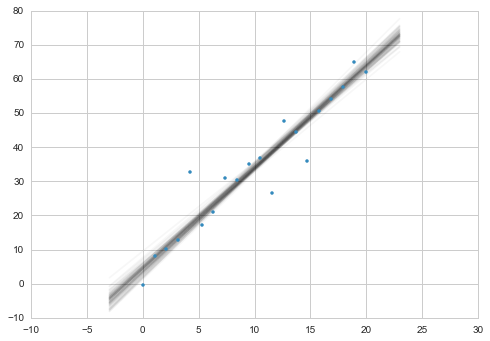

In [147]:
x_p = np.linspace(-3, 23)
for i in range(len(alpha)):
    y_p = alpha[i] * x_p + beta[i]
    plt.plot(x_p, y_p, 'k', alpha=.03)

plt.plot(x, y, '.')

plt.xlim((-10, 30))
plt.ylim((-10, 80))
plt.show()

## Polynoimal Fit

In [5]:
# data

from scipy import io

data = io.loadmat('vars.mat')

In [6]:
data

{'X': array([[-15.93675813],
        [-29.15297922],
        [ 36.18954863],
        [ 37.49218733],
        [-48.05882945],
        [ -8.94145794],
        [ 15.30779289],
        [-34.70626581],
        [  1.38915437],
        [-44.38375985],
        [  7.01350208],
        [ 22.76274892]]),
 '__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Tue Nov 17 17:08:09 2015',
 '__version__': '1.0',
 'y': array([[  2.13431051],
        [  1.17325668],
        [ 34.35910918],
        [ 36.83795516],
        [  2.80896507],
        [  2.12107248],
        [ 14.71026831],
        [  2.61418439],
        [  3.74017167],
        [  3.73169131],
        [  7.62765885],
        [ 22.7524283 ]])}

In [18]:
x = data['X'].flatten()
y = data['y'].flatten()

In [25]:
x.shape, y.shape

((12,), (12,))

(-10, 50)

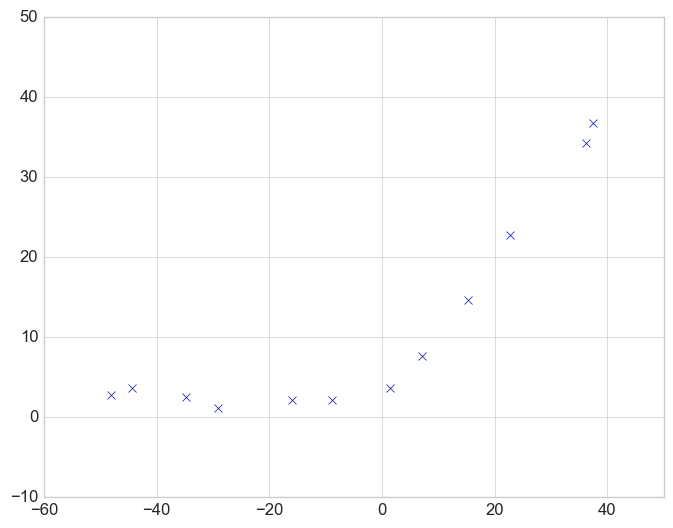

In [8]:
plt.plot(x, y, 'bx')

plt.xlim((-60, 50))
plt.ylim((-10, 50))

In [19]:
# get polynomial features
x_mat = np.c_[x, (x**2), (x**3)]

# standarize the feature
x_mu = x_mat.mean(axis=0)
x_std = x_mat.std(axis=0)

x_mat[:, 0] = (x_mat[:, 0] - x_mu[0]) / x_std[0]
x_mat[:, 1] = (x_mat[:, 1] - x_mu[1]) / x_std[1]
x_mat[:, 2] = (x_mat[:, 2] - x_mu[2]) / x_std[2]

# also standardize the target
y_mu = y.mean()
y_std = y.std()

y_mat = (y - y_mu) / y_std

In [20]:
with pm.Model() as polymol:
    b0 = pm.Normal('b0', sd=50)
    b1 = pm.Normal('b1', sd=50, shape=(3,))
    
    zsigma = pm.Uniform('zsigma', 1.0E-5 , 1.0E-1)
    nuMinusOne = pm.Exponential('nu-1', lam=1/29)
    nu = nuMinusOne + 1
    
    mu = b0 + pm.dot(b1, x_mat.T)
    
    obv = pm.T('observed', mu=mu, nu=nu, lam=1/(zsigma**2), observed=y_mat)
    
    beta0_ = (y_std * b0) + y_mu - y_std * pm.sum(b1 * x_mu / x_std, axis=0)  
    beta1_ = y_std * (b1 / x_std)
    
    beta0 = pm.Deterministic('beta0', beta0_)
    beta1 = pm.Deterministic('beta1', beta1_)  

In [21]:
with polymol:
    start = pm.find_MAP() # Find starting value by optimization
    step1 = pm.NUTS([b1])
    step2 = pm.Metropolis([b0, zsigma])
    trace = pm.sample(10000, [step1, step2], start, progressbar=True)

Assigned <class 'pymc3.step_methods.nuts.NUTS'> to nu-1_log
 [-----------------100%-----------------] 10000 of 10000 complete in 12.3 sec

In [22]:
pm.summary(trace[2000::50], vars=['beta0', 'beta1'])


beta0:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  5.183            0.688            0.071            [3.812, 6.342]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  3.812          4.805          5.223          5.640          6.342


beta1:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.385            0.038            0.004            [0.312, 0.465]
  0.010            0.001            0.000            [0.009, 0.011]
  0.000            0.000            0.000            [0.000, 0.000]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.294          0.367          0.390  

In [23]:
# back to original scale
b0 = trace['b0'][2000::50]
b1 = trace['b1'][2000::50]


beta0 = (y_std * b0) + y_mu - y_std * np.sum(b1 * x_mu / x_std, axis=1)  
beta1 = y_std * (b1 / x_std)

# bb0 = -0.6
# bb1 = np.array([-0.03, 0.016, 0.044])

# beta0 = (y_std * bb0) + y_mu - y_std * np.sum(bb1 * x_mu / x_std)
# beta1 = y_std * (bb1 / x_std)

In [14]:
np.median(beta0)

2.8214927931411116

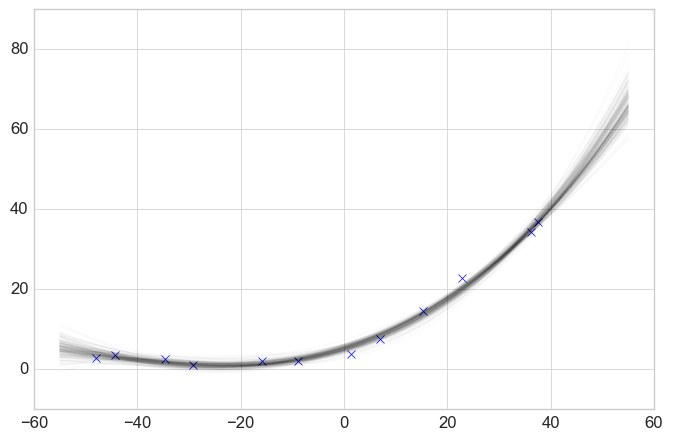

In [41]:
plt.figure(figsize=(8,5))
plt.plot(x, y, 'x')

x_t = np.linspace(-55, 55)
x_pred = np.c_[x_t, (x_t**2), (x_t**3)]


for i in range(len(b1)):
    y_p = np.dot(beta1[i], x_pred.T) + beta0[i]

    plt.plot(x_pred[:, 0], y_p, 'k-', alpha=.02)